# COVID's Effect on Music Trend

Authors: Natnael Mekonnen, Sonya Lew, and Daniel Park

## Introduction

Last semester in spring 2019, we were hit with a COVID-19 pandemic. For the safety of our friends, family and ourselves, we all were forced to social distance, quarantine, and take our academic classes online. With online classes came a lack of face to face interaction with our classmate, TA’s, and our professors making the academic classes harder. It is a fact that everyone has been suffering from this pandemic whether it be a lack of face to face interaction, negative impact on our mental health, unemployment, lose of loved ones, or our health. With such trying times, we were wondering how people may be using music to help cope with the pandemic. More specifically we were wondering if there is a correlation to the pandemic and the songs being played with their traits(I.e. Danceability, tempo,energy, … ) to help cope with these trying times. In this exploration, we will be using these traits in correlation with COVID data to find if pandemic affected the traits of the music we listen to. 

## 1. Data Scraping

To explore the pandemic's effect on music, we chose to compare the COVID data in the US with the top 10 list on Spotify since January 2020. The reason why we chose to focus on the US is because we have more reliable, accessible, and robust data. The COVID data will be extracted from the Atlantic's [The COVID Tracking Project](https://covidtracking.com/data/national) which has been constantly updating the data everyday with representatives from 50 states, 5 territories, and District of Colombia. On the other hand, the Spotify top 10 will be extracted from the [Spotify Charts](https://spotifycharts.com/) on a weekly starting from January 2020. The charts does not have a detail information on the song so we will get more detail by querying the Spotify API.


We imported the necessary libraries: [pandas](https://pandas.pydata.org/pandas-docs/stable/), [matplotlib](https://matplotlib.org/), [numpy](https://numpy.org/doc/), [seaborn](https://seaborn.pydata.org/).

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf

## 1.1 Load and View COVID data

In [53]:
covid_data = pd.read_csv('national-history.csv')
covid_data.head()

,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,recovered,states,totalTestResults,totalTestResultsIncrease
0,12/19/2020,307831.0,2704,34949.0,21688.0,3337,113929.0,641484.0,179327206.0,1185734,3529.0,7790.0,17452905.0,201841,6882996.0,56,230325922,1725036
1,12/18/2020,305127.0,2866,34716.0,21745.0,5240,113955.0,638147.0,178141472.0,1536770,3519.0,7786.0,17251064.0,239246,6762700.0,56,228600886,2197685
2,12/17/2020,302261.0,3438,34485.0,21910.0,5133,114459.0,632907.0,176604702.0,1257526,3504.0,7847.0,17011818.0,240156,6681651.0,56,226403201,1873340
3,12/16/2020,298823.0,3448,34237.0,21946.0,4800,113278.0,627774.0,175347176.0,1200071,3488.0,7778.0,16771662.0,231653,6597661.0,56,224529861,1791968
4,12/15/2020,295375.0,2971,33958.0,21882.0,4398,112814.0,622974.0,174147105.0,1328079,3460.0,7701.0,16540009.0,189783,6490879.0,56,222737893,1781610


The COVID data is detailed but since this project is finding its relationship with music, most of the unnecessary columns will be dropped.

In [54]:
if 'death' in covid_data.columns:
    covid_data = covid_data.drop(['death','deathIncrease','inIcuCumulative','inIcuCurrently', 'hospitalizedIncrease','hospitalizedCurrently','hospitalizedCumulative','onVentilatorCumulative','onVentilatorCurrently','recovered','states'], axis=1)

Knowing that the Spotify data is grouped on a weekly basis starting on a Friday, the next step is to prepare the COVID data so it is easy to merge.

In [55]:
# Creating a custom interval index for grouping the data which starts from begining of the year on a Friday and continues weekly
i = pd.to_datetime('01/10/2020')
bins = []
while i < pd.to_datetime('12/05/2020'):
    temp = i + pd.Timedelta('7 days')
    bins.append((i,temp))
    i = temp
bins = pd.IntervalIndex.from_tuples(bins) 

In [56]:
# Convert the date from the dataframe to a pandas date and time format to be comuted in the cutting
covid_data['date'] = pd.to_datetime(covid_data['date'])

# Using the interval index created above, create a new column week which has the week interval of the data
covid_data['week'] = pd.cut(covid_data['date'], bins)

# Now that every row has a week interval, they will be grouped with the total for each column 
grouped_covid = covid_data.groupby(['week']).sum()

# Number the weeks to easily identify
grouped_covid['week_num'] = list(range(1,len(bins)+1))

grouped_covid.head()

,negative,negativeIncrease,positive,positiveIncrease,totalTestResults,totalTestResultsIncrease,week_num
week,,,,,,,
"(2020-01-10, 2020-01-17]",0.0,0,0.0,0,0,0,1
"(2020-01-17, 2020-01-24]",0.0,0,10.0,2,5,2,2
"(2020-01-24, 2020-01-31]",0.0,0,14.0,0,28,6,3
"(2020-01-31, 2020-02-07]",0.0,0,23.0,3,89,8,4
"(2020-02-07, 2020-02-14]",0.0,0,38.0,2,140,6,5


In [57]:
column_names = ['week_num','positiveIncrease','negativeIncrease','positive','negative','totalTestResultsIncrease','totalTestResults']
grouped_covid = grouped_covid.reindex(columns=column_names)

grouped_covid.head()

,week_num,positiveIncrease,negativeIncrease,positive,negative,totalTestResultsIncrease,totalTestResults
week,,,,,,,
"(2020-01-10, 2020-01-17]",1,0,0,0.0,0.0,0,0
"(2020-01-17, 2020-01-24]",2,2,0,10.0,0.0,2,5
"(2020-01-24, 2020-01-31]",3,0,0,14.0,0.0,6,28
"(2020-01-31, 2020-02-07]",4,3,0,23.0,0.0,8,89
"(2020-02-07, 2020-02-14]",5,2,0,38.0,0.0,6,140


## 1.2 Load and View Spotify Top 10 Weekly Data

As mentioned above, the weekly Spotify top 10 list for 2020 has been downloaded as a csv file. However, since the data is not robust, the Spotify developer API was used to get more detail information on the songs and collectively stored under [`data10.csv`](https://github.com/sonyal/COVIDSpotifyTrends/blob/main/data10.csv). The script to run this process is under [`spotify_data_extraction.py`](https://github.com/sonyal/COVIDSpotifyTrends/blob/main/spotify_data_extraction.py).

In [58]:
spotify_data = pd.read_csv('data.csv')
spotify_data.head()

,name,album,artist,release_date,length,popularity,danceability,acousticness,danceability.1,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,start_date,end_date
0,The Box,Please Excuse Me For Being Antisocial,Roddy Ricch,2019-12-06,196652,90,0.896,0.1040,0.896,0.586,0.00000,0.7900,-6.687,0.0559,116.971,4,2020-01-03,2020-01-10
1,ROXANNE,ROXANNE,Arizona Zervas,2019-10-10,163636,88,0.621,0.0522,0.621,0.601,0.00000,0.4600,-5.616,0.1480,116.735,5,2020-01-03,2020-01-10
2,Yummy,Yummy,Justin Bieber,2020-01-03,210426,79,0.687,0.3660,0.687,0.514,0.00000,0.1160,-6.612,0.0897,145.921,4,2020-01-03,2020-01-10
3,Circles,Hollywood's Bleeding,Post Malone,2019-09-06,215280,90,0.695,0.1920,0.695,0.762,0.00244,0.0863,-3.497,0.0395,120.042,4,2020-01-03,2020-01-10
4,BOP,KIRK,DaBaby,2019-09-27,159714,85,0.769,0.1890,0.769,0.787,0.00000,0.1290,-3.909,0.3670,126.770,4,2020-01-03,2020-01-10


In [59]:
spotify_data['start_date']  = pd.to_datetime(spotify_data['start_date'])

# Using the same interval index created for the covid_data, create a new column week which has the week interval
spotify_data['week'] = pd.cut(spotify_data['start_date'], bins)

# Now that week is included, we can reindex with only the columns we need
spotify_data = spotify_data.reindex(columns=['week','length', 'popularity',
       'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 
       'loudness', 'speechiness', 'tempo', 'time_signature'])

spotify_data.tail()

,week,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
1465,NaN,154424,9,0.651,0.5190,0.631,0.000579,0.1650,-5.717,0.0896,127.994,4
1466,NaN,183290,87,0.794,0.0125,0.793,0.000000,0.0952,-4.521,0.0842,123.941,4
1467,NaN,189486,90,0.764,0.8370,0.320,0.000000,0.0822,-7.209,0.0546,91.019,4
1468,NaN,239835,89,0.511,0.3490,0.566,0.000000,0.3400,-7.230,0.2000,83.903,4
1469,NaN,194087,89,0.701,0.3280,0.425,0.130000,0.1000,-10.965,0.3750,135.128,4


In [60]:
# Now that every row has a week interval, they will be grouped with the mean for each column. The following table will contain
# Spotify data during the pandemic 
grouped_spotify = spotify_data.groupby(['week']).mean()
grouped_spotify.head()


,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
week,,,,,,,,,,,
"(2020-01-10, 2020-01-17]",215694.400000,76.800000,0.736567,0.251691,0.543553,0.034003,0.202063,-7.607967,0.161413,121.679600,4.033333
"(2020-01-17, 2020-01-24]",197874.266667,79.166667,0.725900,0.249792,0.580533,0.030814,0.171410,-6.569833,0.160277,130.922133,4.033333
"(2020-01-24, 2020-01-31]",198965.700000,81.166667,0.726300,0.250979,0.565867,0.030795,0.178673,-6.502900,0.160463,128.848500,4.033333
"(2020-01-31, 2020-02-07]",192784.100000,79.600000,0.719967,0.212842,0.594967,0.022089,0.194757,-6.277200,0.137230,128.143767,4.000000
"(2020-02-07, 2020-02-14]",197652.433333,78.333333,0.733367,0.259486,0.574333,0.022342,0.167743,-6.568800,0.141607,129.174133,4.033333


## 1.3 Merge the Spotify and Covid Data

In [61]:
merged = grouped_covid.merge(grouped_spotify, left_on='week', right_on='week')[:46]
merged.tail()

,week_num,positiveIncrease,negativeIncrease,positive,negative,totalTestResultsIncrease,totalTestResults,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
week,,,,,,,,,,,,,,,,,,
"(2020-10-23, 2020-10-30]",42,548531,6442855,60987944.0,8.159270e+08,8724944,1001566752,185245.733333,89.066667,0.673300,0.245777,0.594900,0.000036,0.146427,-6.677767,0.121507,120.441200,3.900000
"(2020-10-30, 2020-11-06]",43,755922,7010609,65678833.0,8.625697e+08,9554208,1064977639,188892.200000,91.833333,0.696067,0.258977,0.617433,0.000303,0.165863,-6.788200,0.123557,120.558833,3.966667
"(2020-11-06, 2020-11-13]",44,971012,7293300,71671302.0,9.129258e+08,10192332,1134487741,193855.100000,91.300000,0.690100,0.241555,0.597300,0.004369,0.133317,-6.791800,0.140933,125.320600,3.966667
"(2020-11-13, 2020-11-20]",45,1169882,8311319,79323733.0,9.680047e+08,11799518,1212343446,184234.300000,92.333333,0.689467,0.268086,0.590600,0.004340,0.155223,-7.175900,0.111603,122.797867,3.966667
"(2020-11-20, 2020-11-27]",46,1167379,8847032,87662357.0,1.030074e+09,12496773,1300019098,181267.100000,89.600000,0.661500,0.344055,0.568900,0.004360,0.175580,-7.995867,0.099927,125.403267,3.933333


## 2. Data Analysis and Visualization

For the analysis and visualization, it is imperative to find the correlations between the various song features with the COVID data. 

## 2.1 Correlation Heat Map

A correlation heat map on the merged dataframe will help visualize the columns with similar linear trends.

Text(0.5, 1.0, 'Correlation of Spotify and COVID Data')

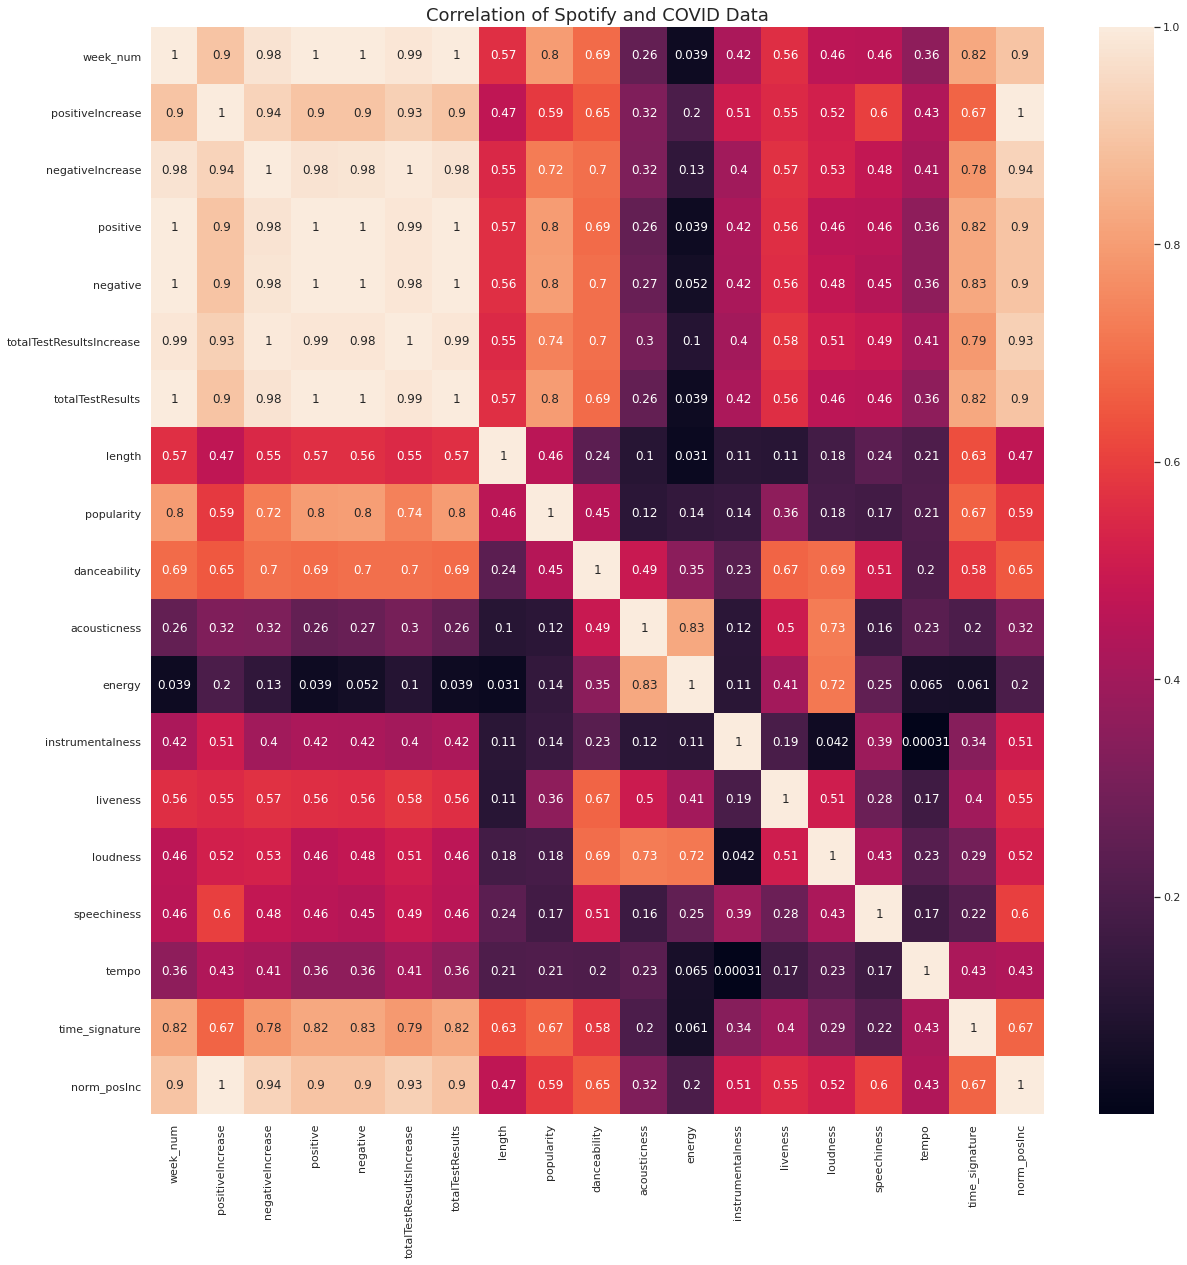

In [78]:
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(abs(merged.corr(method="spearman")), annot=True).set_title('Correlation of Spotify and COVID Data', fontsize=18)

The above graph shows the correlation of the columns where lighter color signifies strong correlation and darker color signifies weak correlation. We can observe the strong relationships between the positive increase for COVID and danceability of the top 10 songs for the relative week. Another observation is that popularity of a song is positively correlated with the positive increase. This can be due to number of streamers increase during these times. In this project, we will further explore the correlation with danceability.

## 2.2 Danceability of Top 10 Songs vs Positive Test Increase

In order to graph the positive increase with danceability, we have to normalize it as the danceability variable ranges from 0 to 1. In this case, min-max (rescale) normalization is used on positive increase to rescale to range from 0 to 1.

In [63]:
merged['norm_posInc'] = (merged.positiveIncrease-merged.positiveIncrease.min())/(merged.positiveIncrease.max()-merged.positiveIncrease.min())

In [64]:
# calculate slope
x = range(0, len(merged.week_num))
posInc_reg = np.polyfit(x, merged.norm_posInc, 1)
posInc_line = np.poly1d(posInc_reg)

dance_reg = np.polyfit(x, merged.danceability, 1)
dance_line = np.poly1d(dance_reg)

print(f'Slope of trend in positive test increase: {posInc_line.c[0]}')
print(f'Slope of trend in danceability of top songs: {dance_line.c[0]}')


Slope of trend in positive test increase: 0.014381765835648482
Slope of trend in danceability of top songs: -0.0018759379175660401


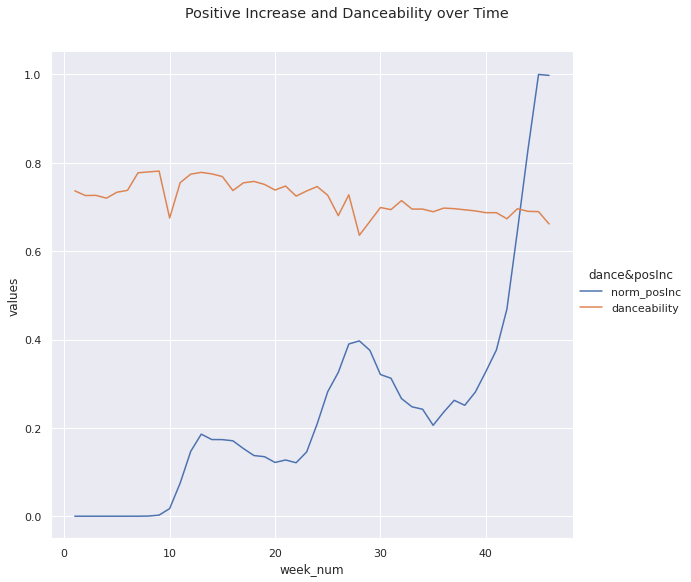

In [65]:
melted_merge = merged[['week_num', 'norm_posInc', 'danceability']]
melted_merge = melted_merge.melt('week_num', var_name='dance&posInc', value_name='values')

sns.relplot(data=melted_merge, x='week_num', y='values', hue='dance&posInc', kind='line',height=8, aspect=1).fig.suptitle('Positive Increase and Danceability over Time')
plt.subplots_adjust(top=0.9)

From the above graph, it can be seen that when the number of positve increase per week increases the danceability of the top 10 songs also decreases. More specifially around week 10 and week 28 which are both significant week when COVID spiked. Week 10 is around March when the stay at home orders were in place and week 28 is around July when everyone went outside to celebrate 4th of July. It is clear that there is a relationship between danceability with positve test increase when it spiked, but to see if in danceability is affected in general, further exploration is needed.

## 2.3 Pre-COVID vs. During COVID

Now we'll extract Spotify's Top 10 song data from before COVID to compare how trends changed throughout the year before COVID 
Starting on 2/15/19 until 2/25/20 the beginning of COVID in the U.S. (when we had our first positive cases)

In [66]:
pre_spotify = pd.read_csv('pre_data.csv')
pre_spotify.sort_values(by=['start_date'], inplace=True)

In [67]:

# We want to analyze Spotify data from January 2019 to January 2020 to compare to Spotify data when the first tests were administered
i = pd.to_datetime('01/11/2019')
pre_bins = []
while i < pd.to_datetime('01/04/2020'):
    temp = i + pd.Timedelta('7 days')
    pre_bins.append((i,temp))
    i = temp
pre_bins = pd.IntervalIndex.from_tuples(pre_bins)

In [68]:

pre_spotify['start_date'] = pd.to_datetime(pre_spotify['start_date'])

# Using the interval index created above, create a new column week which has the week interval of the data
pre_spotify['week'] = pd.cut(pre_spotify['start_date'], pre_bins)

# Now that every row has a week interval, they will be grouped with the total for each column 
pre_spotify = pre_spotify.groupby(['week']).mean().reset_index()

# Number the weeks to easily identify
pre_spotify['week_num'] = list(range(1,len(pre_bins)+1))
pre_spotify = pre_spotify.reset_index()
grouped_pre = pre_spotify[:52]

In [69]:
pre_spotify = grouped_pre.groupby(['week_num']).mean()
pre_spotify.head()

,index,length,popularity,danceability,acousticness,danceability.1,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
week_num,,,,,,,,,,,,,
1,0,194228.5,61.3,0.8066,0.268243,0.8066,0.5552,0.000001,0.16057,-6.4254,0.15057,105.0623,4.0
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4,193647.6,63.8,0.7991,0.255160,0.7991,0.5111,0.000125,0.16664,-7.8419,0.14818,114.6845,4.0


In [70]:
# during_spotify = grouped_spotify
# during_spotify = during_spotify.reset_index()


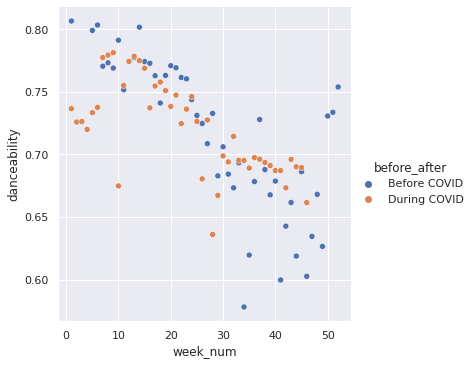

In [71]:
# How do the trends in top Spotify songs compare to trends pre-COVID?

grouped_spotify['week_num'] = list(range(1,len(grouped_spotify)+1))

temp1 = grouped_pre
temp2 = grouped_spotify
temp1["before_after"] = np.array("Before COVID")
temp2["before_after"] = np.array("During COVID")

all_spotify = temp1.append(temp2)

sns.relplot(y="danceability", x="week_num", hue="before_after", data=all_spotify)

# Pre-COVID significantly higher danceability and energy
# Speaks to what artists are writing/producing as well as what ppl are listening to

# blue is pre-covid

Top 10 songs on Spotify pre-COVID:
	Slope of trend of danceability: nan
	Standard deviation of danceability: 0.06105913598090537

Top 10 songs on Spotify during COVID:
	Slope of trend in danceability: nan
	Standard deviation of danceability: 0.036512539011951804


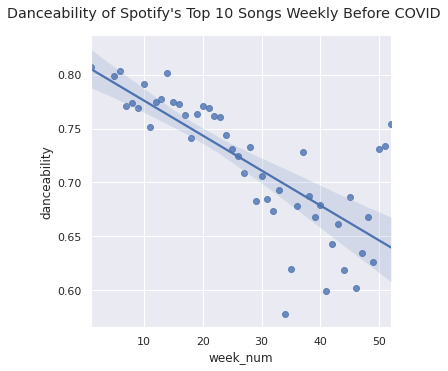

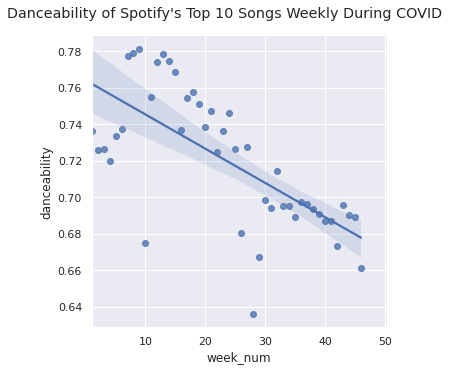

In [72]:
pre_spotify.reset_index(inplace=True)
fig = sns.lmplot(y="danceability", x="week_num", data=pre_spotify);
fig = fig.fig
fig.suptitle("Danceability of Spotify's Top 10 Songs Weekly Before COVID")
fig.subplots_adjust(top=0.9)

fig = sns.lmplot(y="danceability", x="week_num", data=grouped_spotify);
fig = fig.fig
fig.suptitle("Danceability of Spotify's Top 10 Songs Weekly During COVID")
fig.subplots_adjust(top=0.9)

x = range(0, len(pre_spotify.week_num))
pre_reg = np.polyfit(x, pre_spotify.danceability, 1)
pre_line = np.poly1d(pre_reg)

x = range(0, len(grouped_spotify.week_num))
during_reg = np.polyfit(x, grouped_spotify.danceability, 1)
during_line = np.poly1d(during_reg)


print('Top 10 songs on Spotify pre-COVID:')
print(f'\tSlope of trend of danceability: {pre_line.c[0]}\n\tStandard deviation of danceability: {pre_spotify.danceability.std()}\n')

print('Top 10 songs on Spotify during COVID:')
print(f'\tSlope of trend in danceability: {during_line.c[0]}\n\tStandard deviation of danceability: {grouped_spotify.danceability.std()}')


## 3. Predicting Trends Future Trends

We already examined the relationship between the number of positive COVID cases and characteristics of top 10 Spotify songs and found that there is a predictive relationship between the number of positive COVID cases and the danceability and popularity of Spotify's top 10 songs based on their correlation coefficients. There also is a predictive relationship between the increase in number of positive cases and the danceability and popularity of these songs.

Let's predict how these trends will continue as the pandemic progresses.


We'll use sklearn to conduct our machine learning regression algorithm. Since


      positive  positiveIncrease     dance
35  45770109.0            275553  0.697433
39  54593166.0            382842  0.687100
15   7142510.0            199738  0.737200
9      80769.0             20212  0.674833
19  11782326.0            142362  0.738367
29  33137630.0            375242  0.698800
16   8458881.0            179166  0.754667
24  18408924.0            329827  0.726400
11   1408371.0            171784  0.774300
10    460837.0             87791  0.755100
6         74.0                 8  0.777400
38  52090412.0            328587  0.691133
12   2828628.0            217297  0.778333
22  14901811.0            170192  0.736200
36  47819726.0            306929  0.696200
26  23885427.0            456038  0.727500
44  79323733.0           1169882  0.689467
46  95783170.0           1258232       NaN
42  65678833.0            755922  0.696067
28  30296402.0            439179  0.667267
45  87662357.0           1167379  0.661500
32  40148706.0            289645  0.695233
17   962389

<AxesSubplot:xlabel='danceability', ylabel='Density'>

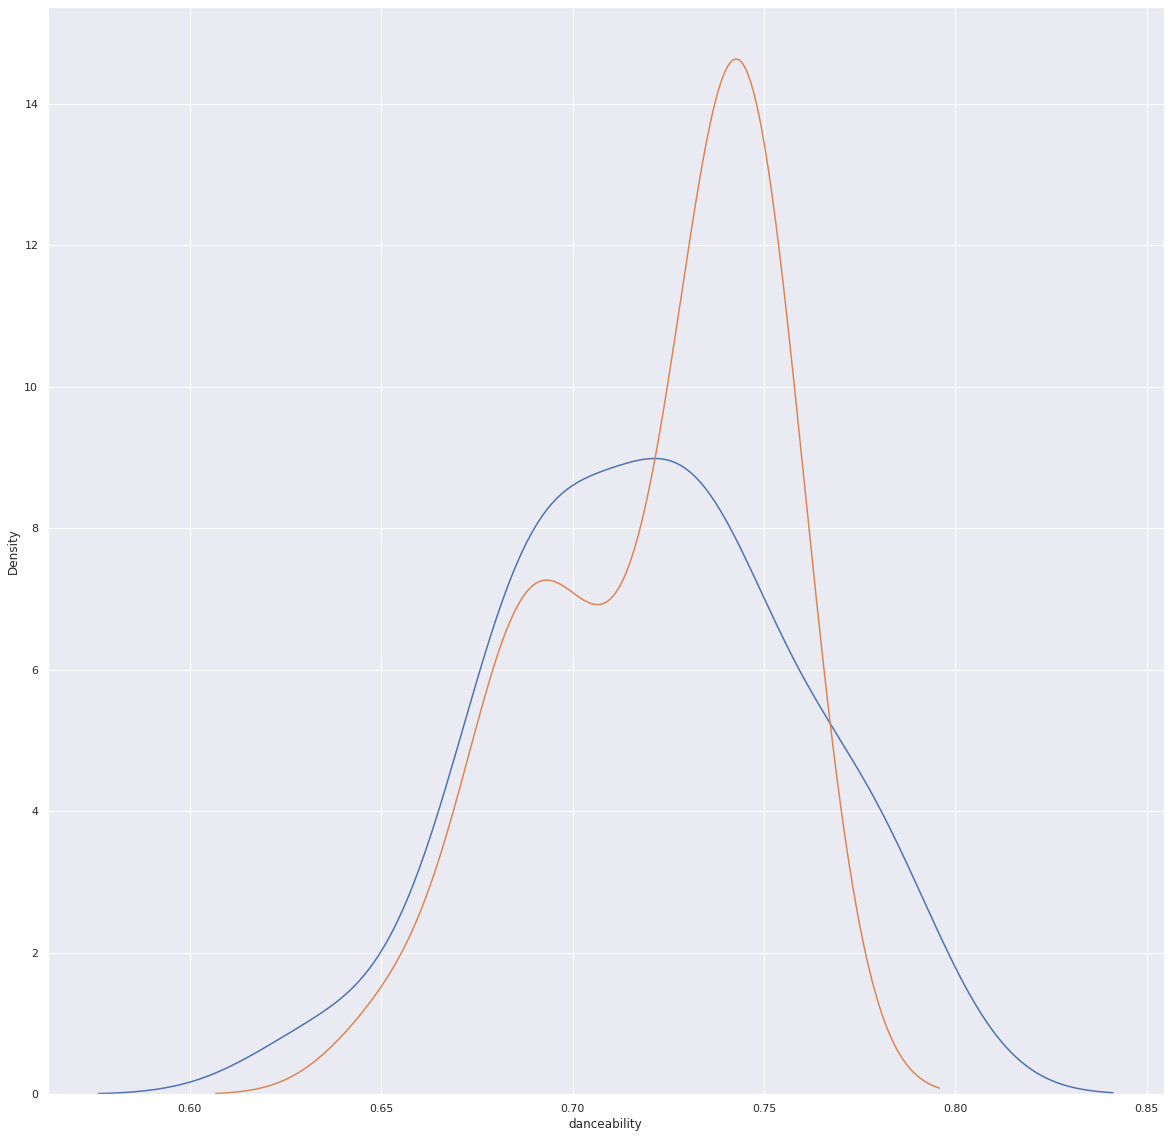

In [73]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn import model_selection

X = grouped_covid.reset_index()[['positive', 'positiveIncrease']]
y = grouped_spotify['danceability']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.5)
X_train['dance'] = y_train.values
print(X_train)
lr = smf.ols(formula='dance ~ positive + positiveIncrease', data=X_train).fit()
preds_lr = lr.predict(X_test)

f, ax = plt.subplots()
sns.distplot(y_test, hist=False, label="Actual", ax=ax)
sns.distplot(preds_lr, hist=False, label="Linear Regression Predictions", ax=ax)

In [74]:
from scipy.stats import f as ft

# F-Test to evaluate goodness of fit

test = lr.f_test(np.identity(len(lr.params)))
print(' Model - Calculated F-Statistic: ' + str(ft.ppf(.95,test.df_num,test.df_denom)) + \
    ' F-Value: ' + str(test.fvalue[0][0]) + ' P-Value: ' + str(test.pvalue))

 Model - Calculated F-Statistic: 3.492828476735632 F-Value: 5008.625792010087 P-Value: 9.86624413693638e-28
/home/codespace/workspace/COVIDSpotifyTrends/pythonenv3.8/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


<AxesSubplot:xlabel='popularity', ylabel='Density'>

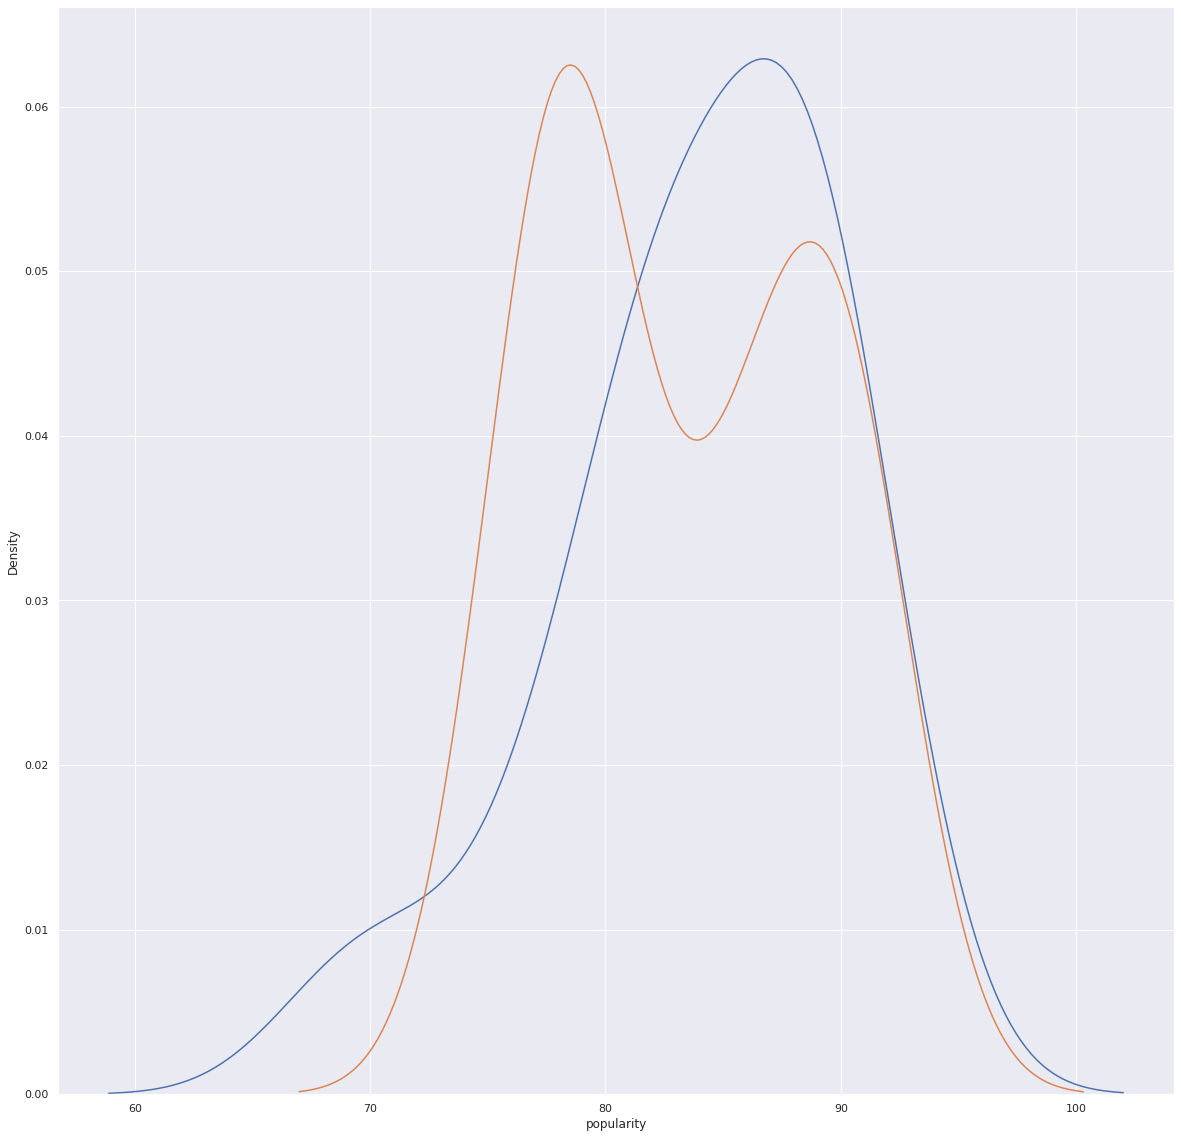

In [75]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

X = grouped_covid.reset_index()[['positive', 'positiveIncrease']]
y = grouped_spotify['popularity']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.5)
X_train['pop'] = y_train.values

lr = smf.ols(formula='pop ~ positive + positiveIncrease', data=X_train).fit()
preds_lr = lr.predict(X_test)

f, ax = plt.subplots()
sns.distplot(y_test, hist=False, label="Actual", ax=ax)
sns.distplot(preds_lr, hist=False, label="Linear Regression Predictions", ax=ax)

In [76]:
# F-Test to evaluate goodness of fit

test = lr.f_test(np.identity(len(lr.params)))
print(' Model - Calculated F-Statistic: ' + str(ft.ppf(.95,test.df_num,test.df_denom)) + \
    ' F-Value: ' + str(test.fvalue[0][0]) + ' P-Value: ' + str(test.pvalue))

 Model - Calculated F-Statistic: 3.492828476735632 F-Value: 1247.0594149780566 P-Value: 1.0149436921362835e-21
/home/codespace/workspace/COVIDSpotifyTrends/pythonenv3.8/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


These models for predicting the characteristics of trending songs using positive COVID cases as a predictor 
is statistically significant.
The F-Values are greater than the F-Statistics and all p-values are <0.05